# Reporte de avance: Proyecto de Georreferenciación PS

## Abstract
**Problema** - Se busco georeferenciar los registros de ingresos del plan de salud del periodo 2014 al 2020 <br>
**Metodo** - Se dividio el problema en dos partes. La primera parte intento asignar direcciones normalizadas utilizando el codigo postal ingresado. La segunda parte utilizo esta informacion extra, junto a la informacion ya conocida, y por medio de consultas con la API de [GeoRefAR](https://datosgobar.github.io/georef-ar-api/) para asignar campos normalizados y georeferenciados. <br>
**Resultados** - El **44.6%** de los registros (48408) fueron **geolocalizados** y sus **localidades** fueron **normalizadas**. <br>
**Proximas fases** - Georeferenciar a nivel de domicilio cada registro. Modificar los formularios usados en el registro de ingresos.<br>

## Exploracion inicial
La actual pipeline esta pensada para aproximar la geolocalizacion de los registros de ingresos del plan de salud del HI (desde el 2014 al 2020) en base a 3 varaibles proveidas: <br>
## Resumen 
La actual pipeline esta pensada para aproximar la geolocalizacion de los usuarios del plan de salud del HI (desde el 2014 al 2020) en base a 3 variables proveidas: <br>
`provincia_part`, `cp_part`, `loc_part`.<br>

Un analisis exploratorio reveló que usualmente los usuarios escriben campos erroneos en la localidad (a veces el municipio, a veces sencillamente comente errores tipeando) y tambien en la provincia (ej Bariloche anotado como Capital Federal, etc). 

Un primer analisis exploratorio del padron revelo los siguientes valores ausentes para los 87402 usuarios evaluados:
```bash 
nacionalidad       206

provincia_part    4820

loc_part           263

cp_part              1
```
A su vez encontramos que usualmente los CP al ser valores estrucurados son bastante fidedignos de la verdadera ubicacion del usuario. Es decir, pueden ser muy precisos, indicando una localidad especifica. Sin embargo a veces no lo son tanto, pudiendo inclusive corresponder a dos provincias al mismo tiempo (mas comun en el interior del pais).

Si nos concentramos en los usarios que son mas relevantes dada su ubicacion geografica (BS AS y CABA) observamos que componen el 93.7% del padrón (81925 usuarios). En el caso de los socios de CABA, la respuesta mas comun a la pregunta de la localidad en la que viven (`loc_part`) fue CABA (36988) o CDAD AUTONOMA BS AS (6703). Este ultimo probablemente sea un campo estructurado pero no se comprende por que no todos los usuarios usaron esta modalidad. Quizas la base tomo informacion de distintas fuentes y formularios (sin embargo ambas modalidades, CABA y CDA aparecen en todos los años).

In [2]:
# Cargando librerias
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
import shapely
import geoplot
import get_centroides

In [3]:
df = pd.read_csv('./HI_usuarios_completos.csv',  encoding='latin-1') # Datos de los usuarios 

## Ejemplo de un fragmento del dataset inicial utilizado

In [4]:
df.sample(5)

,anio_ing,nacionalidad,provincia_part,loc_part,cp_part
403,2014,AR,BA,SAN JUSTO,1754
49730,2018,AR,CF,CABA,1425
55222,2018,AR,CF,CABA,1223
30272,2015,AR,BA,CASTELAR,1712
47642,2017,AR,CF,CABA,1010


# Algoritmo utilizado

**Fase 1: Códigos postales y localidades**

1) Asignar campos segun codigo postal (`cp_part`)
- 1.1) Si es de Capital ver si el CP corresponde a una localidad unica (barrio). Si es asi se asigna Localidad, Departamento (Comuna) y Provincia<br>
-  1.2) Si no corresponde a una localidad unica se checa si el CP corresponde a una unica comuna. Si es asi se asigna solo Departamento y Provincia. Sino solo se asigna Provincia `CIUDAD AUTONOMA DE BUENOS AIRES`.<br>
- 1.3) Si es de provincia se checa si el CP corresponde a una unica localidad. Si es asi se asigna localidad y Provincia (no tenemos una tabla que linkee departamentos con CP).<br>
- 1.4) Si no corresponde a una unica localidad se checa si el CP corresponde a una unica provincia. Si es asi se asgina solo Provincia. En todos los casos, cuando el CP no es suficiente para asignar un campo especifico se coloca el valor `NO UNICA/O LOCALIDAD/DEPARTAMENTO/PROVINCIA <br>

**Fase 2: Normalización y georeferenciación**

2) Una vez asignado los campos anterios se correran la funciones de `get_centroides.py` con las siguientes reglas:<br>
- 2.1) Si hay un campo de Provincia registrada se ingresa a la funcion.<br>
- 2.1.1) Si hay un campo de localidad se ingresa a la funcion. Se obtiene el centroide y el id normalizado por INDEC para la localidad.<br>
- 2.1.2) Si no hay localidad habra dos opciones, dependiendo si es de Capital o Provincia:<br>
    -      Provincia) Se usa el campo Provincia generado y se usa el campo `loc_part` (ingresado por el usuario). Si encuentra una respuesta se agrega la localidad. Sino se agrega centroide de la provincia.<br>
    -     Capital) Se usa la comuna si la hay y se busca por departamento. Si no, se usa el campo 'loc_part' como localidad. Es probabable que no devuelva datos por lo que solo se agrega centroide de Capital Federal.<br>
- 2.2) Si no hay provincia registrada se usa el campo `loc_part`y se ingresa la respuesta. En todos los casos (y campos), si hay  respuesta se ingresa el campo 'NO HUBO REQUEST'
    

## Ejemplo del dataset final obtenido luego de aplicar el algoritmo

In [5]:
augmented_df2 = pickle.load(open('./HI_localizacion_socios.pickle', 'rb'))
augmented_df2.sample(5)

,anio_ing,nacionalidad,provincia_part,loc_part,cp_part,user_id,provincia_por_cp,localidad_por_cp,departamento_por_cp,localidad_por_API,...,provincia_por_API,provincia_id_API,centroide_lat_localidad,centroide_lon_localidad,centroide_lat_municipio,centroide_lon_municipio,centroide_lat_departamento,centroide_lon_departamento,centroide_lat_provincia,centroide_lon_provincia
copy_index,,,,,,,,,,,,,,,,,,,,,
54559,2017,AR,BA,SAN JUSTO,1765,ID_54559,BUENOS AIRES,ISIDRO CASANOVA,None,ISIDRO CASANOVA,...,BUENOS AIRES,6,-34.7184,-58.5778,-34.7702,-58.6254,-34.7702,-58.6254,-36.676942,-60.558832
58743,2015,DESCONOCIDO,CF,CABA,1424,ID_58743,CIUDAD AUTONOMA DE BUENOS AIRES,NO UNICA LOCALIDAD,NO UNICO DEPARTAMENTO,NO HUBO REQUEST,...,CIUDAD AUTÓNOMA DE BUENOS AIRES,2,NO HUBO REQUEST,NO HUBO REQUEST,NO HUBO REQUEST,NO HUBO REQUEST,NO HUBO REQUEST,NO HUBO REQUEST,-34.614493,-58.445856
6635,2014,AR,BA,SAN JUSTO,1754,ID_6635,BUENOS AIRES,NO UNICA LOCALIDAD,None,SAN JUSTO,...,BUENOS AIRES,6,-34.6882,-58.5627,-34.7702,-58.6254,-34.7702,-58.6254,-36.676942,-60.558832
45847,2017,AR,CF,CABA,1408,ID_45847,CIUDAD AUTONOMA DE BUENOS AIRES,NO UNICA LOCALIDAD,NO UNICO DEPARTAMENTO,NO HUBO REQUEST,...,CIUDAD AUTÓNOMA DE BUENOS AIRES,2,NO HUBO REQUEST,NO HUBO REQUEST,NO HUBO REQUEST,NO HUBO REQUEST,NO HUBO REQUEST,NO HUBO REQUEST,-34.614493,-58.445856
13206,2014,AR,BA,RAFAEL CASTILLO,1755,ID_13206,BUENOS AIRES,RAFAEL CASTILLO,None,RAFAEL CASTILLO,...,BUENOS AIRES,6,-34.7132,-58.6258,-34.7702,-58.6254,-34.7702,-58.6254,-36.676942,-60.558832


# Conclusiones
Mientras que nuestro dataset inicial contaba con un **5.51%** de valores ausentes en el campo de provincia, tras correr el algoritmo se pasó a **4.33%** de missing values. En otras palabras, tras correr el algoritmo se obtuvo un incremento de **1030** usuarios con un campo de provincia asignado, normalizada y georeferenciada. 

Cuando analizamos desde una perspectiva mas granular y nos centramos en la localidad observamos que:<br>
**Todos** (100%) los registros de la Provincia de **Buenos Aires** (42447 registros) se les asignó una localidad normalizada y se los georeferenció.<br>
De los registros de la **Capital Federal** (39478 usuarios) sólo se pudo asignar una localidad y geolocalizar al **10.8%** (4272 usuarios) <br>
En **total** un **44.6%** de los registros (48408) fueron **geolocalizados** y sus **localidades** fueron **normalizadas**.

___Recomendaciones___<br>

- Realizar modificaciones en la forma en los que se registran los datos de los usuarios. Principalmente para CABA, en la que los usuarios registren el barrio en el cual viven.
- Si pudieramos contar con informacion del domicilio de los registros podriamos alcanzar un nivel de geolocalizacion mas  preciso y granular. Deberá evaluarse si conviene invertir tiempo para lograr obtener esta información (o si se encuentra en algun lado).

# Posibles aplicaciones de la georeferenciacion

El contar con datos de georeferencia nos permitiria realizar diferentes tareas:

- Identificar el centro de salud mas cercano de cada usuario
- Comunicar novedades sobre centros perifericos mas cercanos a los usuarios
- Identificar distancia de un profesional con sus pacientes (identificacion de clusters)
- Incluir ubicación geográfica como variable en diferentes modelos de machine learning (clasificación y predicción)
- Otras

## Seteo de datos para ejemplificar

In [137]:
# Datos geograficos de los centros perifericos del HI
sedes = pd.read_csv('./geo_data/SEDES_HI.csv')
# Poligonos con informacion de la Capital Federal
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Poligono Argentina
PROVINCIAS = gpd.read_file('./poligonos/provincia_IGN.json') # Poligono Provincias
capital = PROVINCIAS[PROVINCIAS.nam == 'Ciudad Autónoma de Buenos Aires']  # Poligono CABA
comunas_capital = gpd.read_file('./poligonos/CABA_comunas.geojson')  # Poligono Comunas
barrios_capital = gpd.read_file('./poligonos/barrios_solo_capital.geojson')  # Poligono Barrios
municipalidades = gpd.read_file('./poligonos/municipio_IGN.json') # Poligonos municipios

In [34]:
usuario = augmented_df2.iloc[117].copy()  # Elegimos una persona al azar de Capital
usuario['sede_mas_cercana'] = get_centroides.getMinPorTipo(usuario, sedes, tipo = ['CENTRO PERIFERICO', 'HOSPITAL']) 
cerca = sedes[sedes.sede == usuario.sede_mas_cercana[0][2]].copy()  # Sede mas cercana

In [35]:
# Datos de la sede mas cercana
sede_cercana = gpd.GeoDataFrame( { 'Sede' : cerca.sede.values,
                'Provincia' : cerca.provincia.values,
                'Provincia_ID' : cerca.prov_id.values,
                'Localidad' : cerca.localidad.values},
                 geometry = [shapely.geometry.Point(cerca.longitud,cerca.latitud)] , # geometria de la sede cercana
                 index = [0]
)

# Datos del usuario
usuario_df = gpd.GeoDataFrame( { 'Usuario' : usuario.user_id,
                'Provincia' : usuario.provincia_por_API,
                'Provincia_ID' : usuario.provincia_id_API,
                'Localidad' : usuario.localidad_por_API},
                 geometry = [shapely.geometry.Point(usuario.centroide_lon_localidad, usuario.centroide_lat_localidad)],
                 index = [0]
)

# Hospital Italiano
HI = gpd.GeoDataFrame( { 'Sede' : 'CENTRAL',
                'Provincia' : 'CIUDAD AUTONOMA DE BUENOS AIRES',
                'Provincia_ID' : 2,
                'Localidad' : 'ALMAGRO',
                'Localidad_ID' :  2035010001},
                 geometry = [shapely.geometry.Point(-58.428409,-34.6062678)],
                 index = [0]
)

## Ejemplo de funcionamiento y  representacion gráfica del la estimacion de distancia al centro mas cercano



In [36]:
# Ejemplo de un caso 
print("Usuario: ", usuario['user_id'],"\nLocalidad: ", usuario['localidad_por_API'])
print("Sedes mas cercanas: ", usuario['sede_mas_cercana'])

Usuario:  ID_117 
Localidad:  CONSTITUCION
Sedes mas cercanas:  [array([1.742, 'CENTRO PERIFERICO', 'BARRIO NORTE'], dtype=object), array([4.817, 'HOSPITAL', 'CENTRAL'], dtype=object)]


Text(35.75, 0.5, 'Latitud')

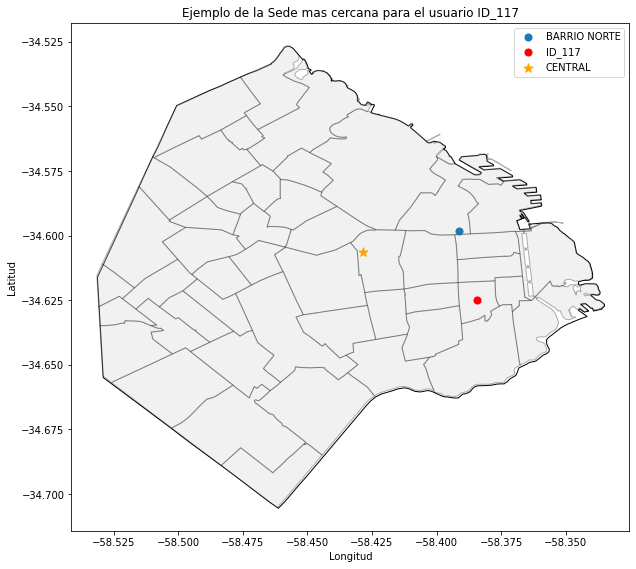

In [37]:
ax = capital.plot(color='white', edgecolor='black', figsize = (10,10), legend = True)  # Poligono de CABA
barrios_capital.plot(column = None, ax = ax, alpha = 0.3, edgecolor = 'k', color = 'lightgray') # Barrios de CABA
sede_cercana.plot(ax = ax , markersize = 50,  label =  sede_cercana.Sede[0])  # Punto de la sede mas cercana
usuario_df.plot(ax = ax, markersize = 50, color = 'red', label =  usuario_df.Usuario[0])  # Punto geografico del usuario
HI.plot(ax = ax, markersize = 90, marker = '*', color = 'orange', label = 'CENTRAL' )  # Punto geografico del  HI
plt.legend()
plt.title(f'Ejemplo de la Sede mas cercana para el usuario {usuario["user_id"]}')
plt.xlabel("Longitud")
plt.ylabel("Latitud")

En este caso podemos ver como el algoritmo detecta que para un registro (`ID_117`) en el cual contamos con datos georeferenciados en el nivel localidad (es decir las coordenadas correspondientes al punto medio de esta localidad, en este caso el punto medio del barrio de `Constitución`) el centro mas cercano es un centro periferico (`BARRIO NORTE` A 1.72 Km).

Para este caso utilizamos los diferentes centros perifericos del Hospital Italino.
Esta base fue construido manualmente scrapeando los datos de la pagina web del italiano. [Fuente] (https://www.hospitalitaliano.org.ar/#!/home/comercial/seccion/1163) <br>
A continuación se muestra un mapa con todas estas sedes.

Text(185.37949830215274, 0.5, 'Latitud')

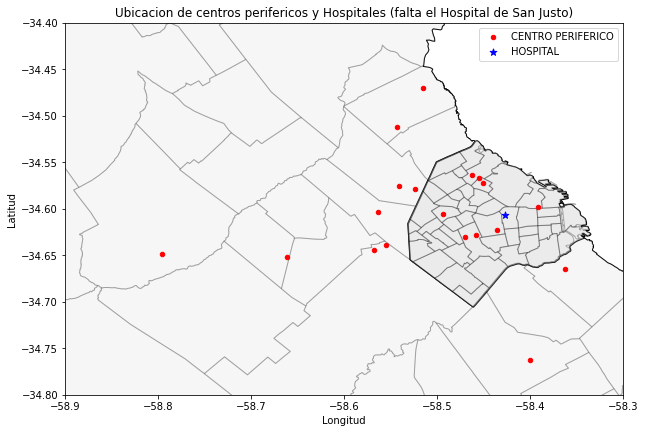

In [145]:
#Crear un geoDataframe con los datos de las sedes
sedes_geom = gpd.GeoDataFrame(sedes.copy())
sedes_geom['geometry'] = sedes_geom.apply(lambda x: shapely.geometry.Point(x.longitud,x.latitud) , axis = 1)

BSAS = PROVINCIAS[PROVINCIAS.nam == 'Buenos Aires']  # Poligono BSAS
ax = BSAS.plot(color='white', edgecolor='black', figsize = (10,10), legend = True)  # Poligono de CABA
ax_cap = capital.plot(color='white', ax = ax ,edgecolor='black', figsize = (10,10), legend = True)  # Poligono de CABA
municipalidades.plot(column = None, ax = ax, alpha = 0.2, edgecolor = 'k', color= 'lightgray') # Localidades BSAS
barrios_capital.plot(column = None, ax = ax, alpha = 0.3, edgecolor = 'k', color = 'lightgray') # Barrios de CABA
# Printeando puntos
sedes_geom[sedes_geom.tipo == 'CENTRO PERIFERICO'].plot(color ='red', markersize = 20, ax = ax, label = 'CENTRO PERIFERICO')
sedes_geom[sedes_geom.tipo == 'HOSPITAL'].plot(color ='BLUE', markersize = 50, marker = '*', ax = ax, label = 'HOSPITAL')
# Handlers
plt.legend()
ax.set_ylim([-34.8,-34.4])
ax.set_xlim([-58.9, -58.3])
plt.title('Ubicacion de centros perifericos y Hospitales (falta el Hospital de San Justo)')
plt.xlabel("Longitud")
plt.ylabel("Latitud")